In [0]:
keys = spark.read.csv('/FileStore/tables/dev_user_databricks_accessKeys.csv', inferSchema=True, header=True)
Access_Id = keys.first()[0]
Secret_Id = keys.first()[1]

access_key = Access_Id
secret_key = Secret_Id
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)

aws_region = "us-east-1"
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df = spark.read.csv('s3://project-bucket-17/Output_RFM_Modelling', inferSchema=True, header=True)
pdf = df.toPandas()
print(pdf.shape)
pdf.head()

(3921, 10)


,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346,325,1,77183.60,1,1,5,115,7,Silver
1,12747,2,103,4196.01,5,4,5,545,14,Diamond
2,12748,0,4596,33719.73,5,5,5,555,15,Diamond
3,12749,3,199,4090.88,5,5,5,555,15,Diamond
4,12820,3,59,942.34,5,4,4,544,13,Platinum


In [0]:
pdf.columns[(pdf == 0).any()]

Out[28]: Index(['Recency', 'Monetary'], dtype='object')

In [0]:
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
pdf['Recency'] = [handle_neg_n_zero(x) for x in pdf.Recency]
pdf['Monetary'] = [handle_neg_n_zero(x) for x in pdf.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = pdf[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

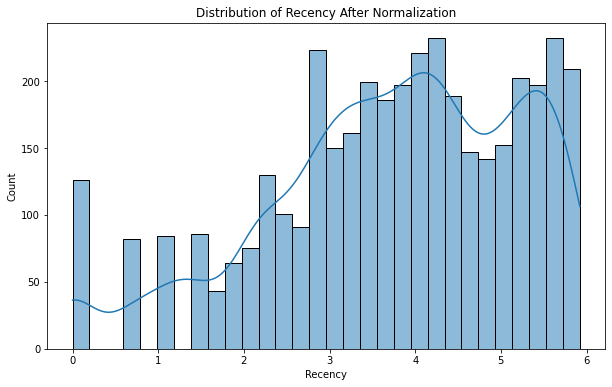

In [0]:
# Data distribution after data normalization for Recency
Recency_Plot = Log_Tfd_Data['Recency']

plt.figure(figsize=(10, 6))
sns.histplot(Recency_Plot, kde=True, bins=30)
plt.title('Distribution of Recency After Normalization')
plt.show()

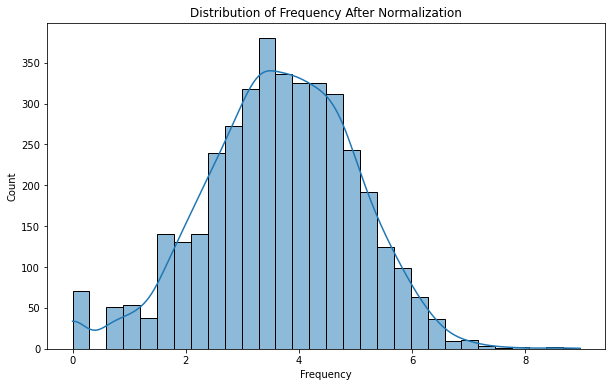

In [0]:
# Data distribution after data normalization for Frequency
# Filter data for Frequency values less than 1000
Frequency_Plot = Log_Tfd_Data.query('Frequency < 1000')['Frequency']

plt.figure(figsize=(10, 6))
sns.histplot(Frequency_Plot, kde=True, bins=30)
plt.title('Distribution of Frequency After Normalization')
plt.show()


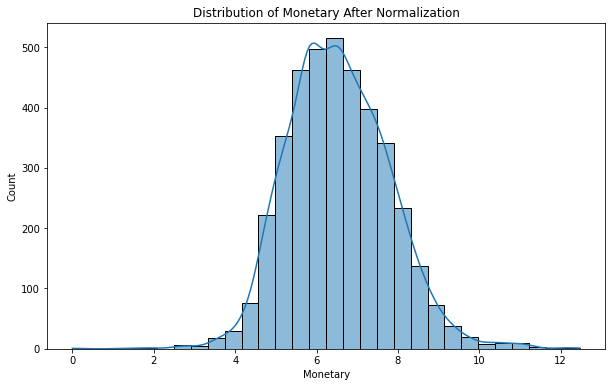

In [0]:
# Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data.query('Monetary < 10000')['Monetary']

plt.figure(figsize=(10, 6))
sns.histplot(Monetary_Plot, kde=True, bins=30)
plt.title('Distribution of Monetary After Normalization')
plt.show()


In [0]:
from sklearn.preprocessing import StandardScaler

# Process the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

# Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = pdf.index, columns = Log_Tfd_Data.columns)

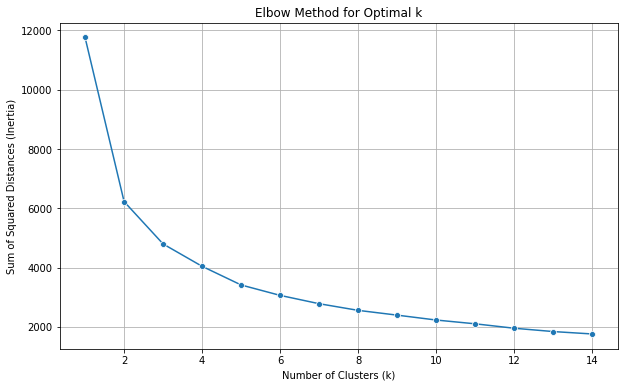

In [0]:
from sklearn.cluster import KMeans

# Dictionary to hold the sum of squared distances (inertia)
sum_of_sq_dist = {}

# Iterate over a range of cluster numbers to fit the KMeans model
for k in range(1, 15):
    km = KMeans(n_clusters=k, max_iter=1000, random_state=0)
    km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_

# Plot the Elbow curve
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
sns.lineplot(x=list(sum_of_sq_dist.keys()), y=list(sum_of_sq_dist.values()), marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [0]:
# Perform K-Means Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters=3, max_iter=1000, random_state=0)
KMean_clust.fit(Scaled_Data)

# Find the clusters for the observations in the dataset
pdf['Cluster'] = KMean_clust.labels_
pdf.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
0,12346,325,1,77183.60,1,1,5,115,7,Silver,0
1,12747,2,103,4196.01,5,4,5,545,14,Diamond,2
2,12748,1,4596,33719.73,5,5,5,555,15,Diamond,2
3,12749,3,199,4090.88,5,5,5,555,15,Diamond,2
4,12820,3,59,942.34,5,4,4,544,13,Platinum,2


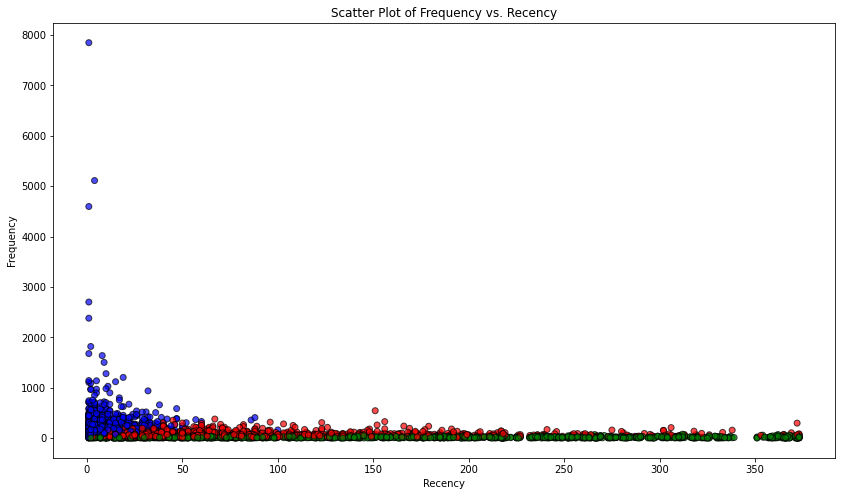

In [0]:
# Define the colors for the clusters
Colors = ["red", "green", "blue"]

# Map cluster labels to colors
pdf['Color'] = pdf['Cluster'].map(lambda p: Colors[p])

plt.figure(figsize=(14, 8))
plt.scatter(
    pdf['Recency'],
    pdf['Frequency'],
    c=pdf['Color'],  # Use the mapped colors
    alpha=0.7,  # Set transparency
    edgecolor='k'  # Add edge color for better separation
)
plt.title('Scatter Plot of Frequency vs. Recency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()


In [0]:
pdf.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster,Color
0,12346,325,1,77183.60,1,1,5,115,7,Silver,0,red
1,12747,2,103,4196.01,5,4,5,545,14,Diamond,2,blue
2,12748,1,4596,33719.73,5,5,5,555,15,Diamond,2,blue
3,12749,3,199,4090.88,5,5,5,555,15,Diamond,2,blue
4,12820,3,59,942.34,5,4,4,544,13,Platinum,2,blue


In [0]:
pdf_spark = spark.createDataFrame(pdf)
pdf_spark = pdf_spark.repartition(1)

In [0]:
# Exporting the file into s3 bucket as a csv format
# pdf_spark.write.mode('overwrite').option("header", "true").csv('s3://project-bucket-17/Output_KMeans')